<a href="https://colab.research.google.com/github/kridtapon/Complete-trading-system-with-monte-carlo-and-walk-forward-optimization/blob/main/Complete_trading_system_with_monte_carlo_and_walk_forward_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.5/527.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninst

[*********************100%***********************]  1 of 1 completed
<ipython-input-35-506eff48fe73>:9: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-35-506eff48fe73>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-35-506eff48fe73>:9: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-35-506eff48fe73>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a futur

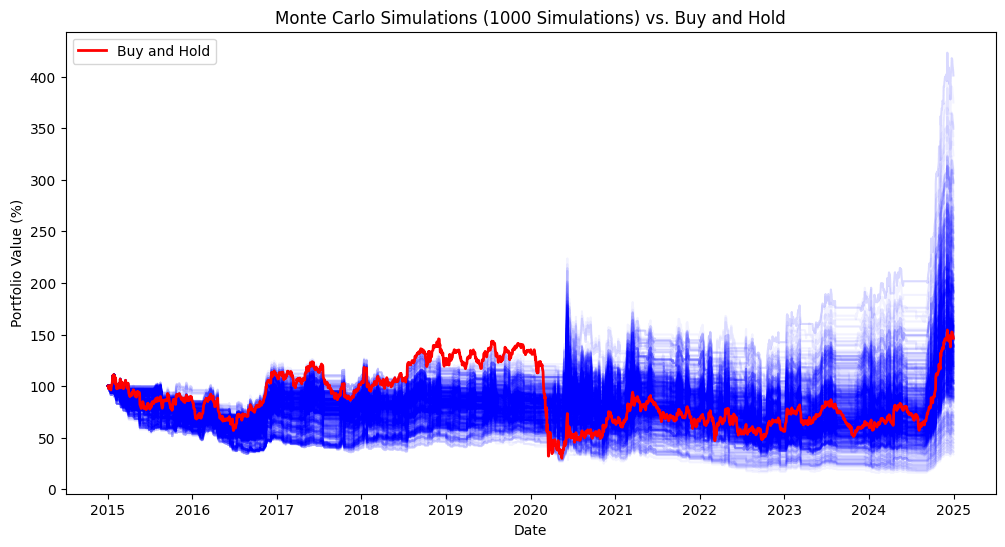

Mean Final Portfolio Value (%): 144.90
Standard Deviation (%): 53.39
Mean Drawdown (%): -60.88
Drawdown Standard Deviation (%): 7.30


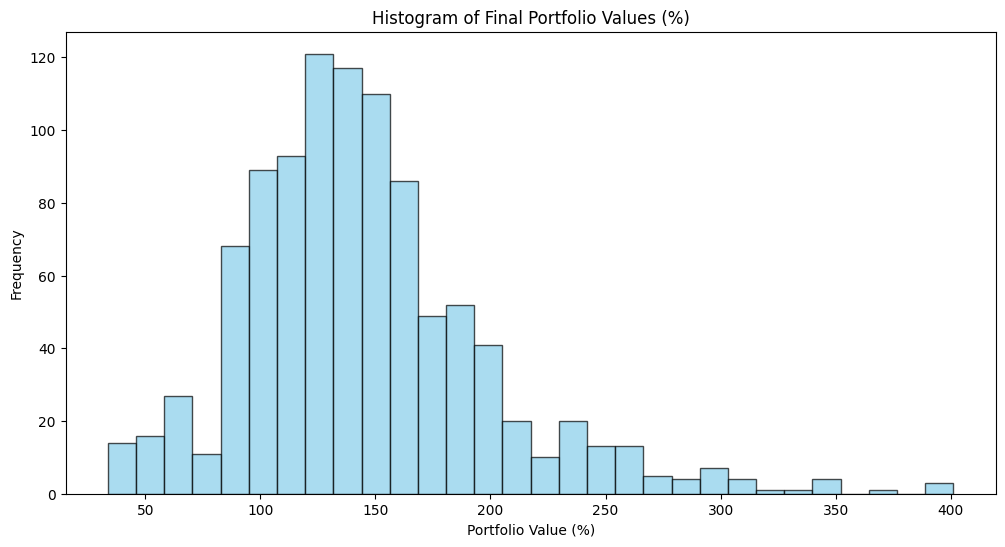

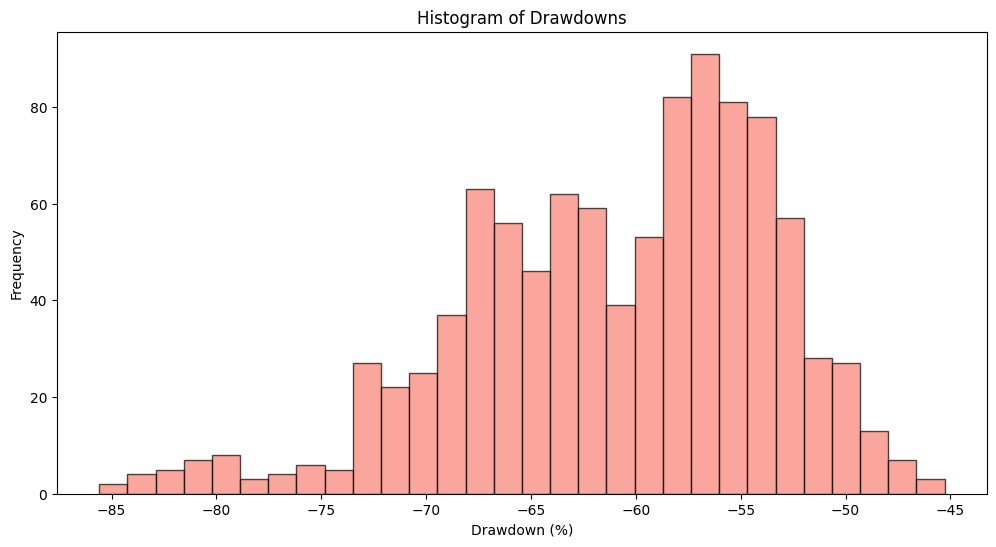

In [35]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt

# Recursive Moving Average (RMA)
def rma(series, alpha=0.1):
    rma_values = [series[0]]
    for i in range(1, len(series)):
        rma_values.append(alpha * series[i] + (1 - alpha) * rma_values[-1])
    return np.array(rma_values)

# Ease of Movement (EMV)
def ease_of_movement(df, period=14):
    df['Distance'] = (df['High'] + df['Low']) / 2 - (df['High'].shift(1) + df['Low'].shift(1)) / 2
    df['Box Ratio'] = (df['Volume'] / 100000) / (df['High'] - df['Low'])
    df['EMV'] = df['Distance'] / df['Box Ratio']
    df['EMV'] = df['EMV'].rolling(window=period).mean()
    return df['EMV']

# Define the stock symbol and time period
symbol = 'UAL'
start_date = '2014-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Monte Carlo Simulation for different alpha and period ranges
def monte_carlo_simulation(df, n_simulations=100, alpha_range=(0.01, 0.5), period_range=(1, 51)):
    all_simulations = []
    drawdowns = []

    for _ in range(n_simulations):
        # Randomly sample alpha and period values
        alpha = np.random.uniform(alpha_range[0], alpha_range[1])
        period = np.random.randint(period_range[0], period_range[1])

        # Calculate RMA and EMV with the sampled parameters
        df['RMA'] = rma(df['Close'], alpha=alpha)
        df['EMV'] = ease_of_movement(df, period=period)

        # Define entry and exit signals
        df['Entry'] = (df['Close'] > df['RMA']) & (df['EMV'] > 0)
        df['Exit'] = (df['Close'] < df['RMA']) & (df['EMV'] < 0)

        # Filter data for test period (e.g., 2015-2025)
        df_test = df[(df.index.year >= 2015) & (df.index.year <= 2025)]

        # Convert signals to boolean arrays
        entries = df_test['Entry'].to_numpy()
        exits = df_test['Exit'].to_numpy()

        # Backtest using vectorbt
        portfolio = vbt.Portfolio.from_signals(
            close=df_test['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        # Scale portfolio values to percentage change (relative to initial value of 100,000)
        percentage_values = portfolio.value() / portfolio.value().iloc[0] * 100

        # Store the scaled portfolio value (in percentage terms) over time for all simulations
        all_simulations.append(percentage_values.to_numpy())

        # Calculate drawdown for this simulation
        drawdown = (percentage_values / percentage_values.cummax() - 1) * 100
        drawdowns.append(drawdown.min())  # Store the maximum drawdown (most negative value)

    return all_simulations, drawdowns

# Run Monte Carlo simulation
n_simulations = 1000  # Number of simulations
simulations, drawdowns = monte_carlo_simulation(df, n_simulations=n_simulations)

# Calculate Buy and Hold strategy
df_test = df[(df.index.year >= 2015) & (df.index.year <= 2025)]
buy_and_hold = (df_test['Close'] / df_test['Close'].iloc[0]) * 100  # Buy and Hold strategy

# Plot all simulations in percentage terms
plt.figure(figsize=(12, 6))
for simulation in simulations:
    plt.plot(df.index[-len(simulation):], simulation, color='blue', alpha=0.05)  # Adjust alpha for transparency

# Plot Buy and Hold on the same graph
plt.plot(df_test.index, buy_and_hold, color='red', label='Buy and Hold', linewidth=2)

plt.title(f'Monte Carlo Simulations ({n_simulations} Simulations) vs. Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (%)')
plt.legend()
plt.show()

# Calculate and display statistics for the final portfolio values in percentage terms
final_values = [simulation[-1] for simulation in simulations]
mean_value = np.mean(final_values)
std_dev = np.std(final_values)
print(f"Mean Final Portfolio Value (%): {mean_value:.2f}")
print(f"Standard Deviation (%): {std_dev:.2f}")

# Calculate and display statistics for drawdowns
mean_drawdown = np.mean(drawdowns)
std_dev_drawdown = np.std(drawdowns)
print(f"Mean Drawdown (%): {mean_drawdown:.2f}")
print(f"Drawdown Standard Deviation (%): {std_dev_drawdown:.2f}")

# Plot histogram of final portfolio values in percentage terms
plt.figure(figsize=(12, 6))
plt.hist(final_values, bins=30, edgecolor='black', color='skyblue', alpha=0.7)
plt.title('Histogram of Final Portfolio Values (%)')
plt.xlabel('Portfolio Value (%)')
plt.ylabel('Frequency')
plt.show()

# Plot histogram of drawdowns
plt.figure(figsize=(12, 6))
plt.hist(drawdowns, bins=30, edgecolor='black', color='salmon', alpha=0.7)
plt.title('Histogram of Drawdowns')
plt.xlabel('Drawdown (%)')
plt.ylabel('Frequency')
plt.show()


In [41]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from sklearn.model_selection import ParameterGrid

# Recursive Moving Average (RMA)
def rma(series, alpha=0.1):
    rma_values = [series[0]]
    for i in range(1, len(series)):
        rma_values.append(alpha * series[i] + (1 - alpha) * rma_values[-1])
    return np.array(rma_values)

# Ease of Movement (EMV)
def ease_of_movement(df, period=14):
    df['Distance'] = (df['High'] + df['Low']) / 2 - (df['High'].shift(1) + df['Low'].shift(1)) / 2
    df['Box Ratio'] = (df['Volume'] / 100000) / (df['High'] - df['Low'])
    df['EMV'] = df['Distance'] / df['Box Ratio']
    df['EMV'] = df['EMV'].rolling(window=period).mean()
    return df['EMV']

# Define the stock symbol and time period
symbol = 'UAL'
start_date = '2014-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Define the function for backtesting with optimization parameters
def backtest_with_parameters(alpha, period):
    # Calculate RMA and EMV
    df['RMA'] = rma(df['Close'], alpha=alpha)
    df['EMV'] = ease_of_movement(df, period=period)

    # Define entry and exit signals based on RMA and EMV
    df['Entry'] = (
        (df['Close'] > df['RMA']) &  # Price closes above RMA
        (df['EMV'] > 0)             # EMV is positive
    )

    df['Exit'] = (
        (df['Close'] < df['RMA']) &  # Price closes below RMA
        (df['EMV'] < 0)             # EMV is negative
    )

    # Filter data for test only
    df_test = df[(df.index.year >= 2015) & (df.index.year <= 2025)]

    # Convert signals to boolean arrays
    entries = df_test['Entry'].to_numpy()
    exits = df_test['Exit'].to_numpy()

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df_test['Close'],
        entries=entries,
        exits=exits,
        init_cash=100_000,
        fees=0.001
    )

    # Return the final portfolio value (to optimize for max returns)
    return portfolio.stats().loc['Total Return [%]']

# Define the grid of parameters to test
param_grid = {
    'alpha': np.linspace(0.01, 0.5),  # alpha from 0.01 to 0.5
    'period': np.arange(1, 51)     # periods from 1 to 50
}

# Create the parameter combinations for grid search
grid = ParameterGrid(param_grid)

# Store the results of the optimization
results = []

# Run grid search
for params in grid:
    alpha = params['alpha']
    period = params['period']

    # Perform backtest for each combination of parameters
    total_return = backtest_with_parameters(alpha, period)
    results.append((alpha, period, total_return))

# Convert results into a DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Alpha', 'Period', 'Total Return [%]'])

# Find the best parameters based on the highest Total Return [%]
best_params = results_df.loc[results_df['Total Return [%]'].idxmax()]

print(f"Best Alpha: {best_params['Alpha']}")
print(f"Best Period: {best_params['Period']}")
print(f"Best Total Return [%]: {best_params['Total Return [%]']:.2f}")

[*********************100%***********************]  1 of 1 completed
<ipython-input-41-eceda8fe4c93>:9: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-41-eceda8fe4c93>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'o

Best Alpha: 0.31
Best Period: 31.0
Best Total Return [%]: 300.74


In [42]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Recursive Moving Average (RMA)
def rma(series, alpha=0.1):
    rma_values = [series[0]]
    for i in range(1, len(series)):
        rma_values.append(alpha * series[i] + (1 - alpha) * rma_values[-1])
    return np.array(rma_values)

# Ease of Movement (EMV)
def ease_of_movement(df, period=14):
    df['Distance'] = (df['High'] + df['Low']) / 2 - (df['High'].shift(1) + df['Low'].shift(1)) / 2
    df['Box Ratio'] = (df['Volume'] / 100000) / (df['High'] - df['Low'])
    df['EMV'] = df['Distance'] / df['Box Ratio']
    df['EMV'] = df['EMV'].rolling(window=period).mean()
    return df['EMV']

# Define the stock symbol and time period
symbol = 'UAL'
start_date = '2014-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Calculate RMA and EMV
df['RMA'] = rma(df['Close'], alpha=0.31)
df['EMV'] = ease_of_movement(df, period=31)

# Define entry and exit signals based on RMA and EMV
df['Entry'] = (
    (df['Close'] > df['RMA']) &  # Price closes above RMA
    (df['EMV'] > 0)             # EMV is positive
)

df['Exit'] = (
    (df['Close'] < df['RMA']) &  # Price closes below RMA
    (df['EMV'] < 0)             # EMV is negative
)

# Filter data for test only
df = df[(df.index.year >= 2015) & (df.index.year <= 2025)]

# Convert signals to boolean arrays
entries = df['Entry'].to_numpy()
exits = df['Exit'].to_numpy()

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
<ipython-input-42-b6974a8b700c>:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-42-b6974a8b700c>:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'o

Start                         2015-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       2516
Start Value                              100000.0
End Value                             400743.5431
Total Return [%]                       300.743543
Benchmark Return [%]                    46.367205
Max Gross Exposure [%]                      100.0
Total Fees Paid                      13079.347602
Max Drawdown [%]                        52.607421
Max Drawdown Duration                      1348.0
Total Trades                                   64
Total Closed Trades                            63
Total Open Trades                               1
Open Trade PnL                      199345.146796
Win Rate [%]                            38.095238
Best Trade [%]                           36.81227
Worst Trade [%]                        -11.775319
Avg Winning Trade [%]                    10.76359
Avg Losing Trade [%]                    -4.097583


[*********************100%***********************]  1 of 1 completed
<ipython-input-54-cd809079b417>:9: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-54-cd809079b417>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-54-cd809079b417>:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd809079b417>:16: SettingWithCopyWarning:


A va

Year 2016: Walk-Forward Optimization Return = 0.12


<ipython-input-54-cd809079b417>:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd809079b417>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd809079b417>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd80

Year 2017: Walk-Forward Optimization Return = -0.09


<ipython-input-54-cd809079b417>:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd809079b417>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd809079b417>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd80

Year 2018: Walk-Forward Optimization Return = 0.01


<ipython-input-54-cd809079b417>:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd809079b417>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd809079b417>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd80

Year 2019: Walk-Forward Optimization Return = 0.15


<ipython-input-54-cd809079b417>:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd809079b417>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd809079b417>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd80

Year 2020: Walk-Forward Optimization Return = -0.08


<ipython-input-54-cd809079b417>:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd809079b417>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd809079b417>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd80

Year 2021: Walk-Forward Optimization Return = 0.01


<ipython-input-54-cd809079b417>:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd809079b417>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd809079b417>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd80

Year 2022: Walk-Forward Optimization Return = -0.06


<ipython-input-54-cd809079b417>:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd809079b417>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd809079b417>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd80

Year 2023: Walk-Forward Optimization Return = 0.14


<ipython-input-54-cd809079b417>:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd809079b417>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd809079b417>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-54-cd80

Year 2024: Walk-Forward Optimization Return = 0.76

Walk-Forward Optimization Results:
   Year                 Best_Params  Test_Return
0  2016                   (0.46, 1)     0.118971
1  2017                  (0.13, 42)    -0.088746
2  2018  (0.060000000000000005, 18)     0.008475
3  2019   (0.41000000000000003, 13)     0.152739
4  2020                  (0.43, 12)    -0.078202
5  2021    (0.48000000000000004, 1)     0.006276
6  2022                  (0.31, 31)    -0.062143
7  2023                  (0.33, 28)     0.137182
8  2024                   (0.13, 7)     0.761236

Buy-and-Hold Performance:
Year 0: Buy-and-Hold Return = 0.10
Year 1: Buy-and-Hold Return = 0.02
Year 2: Buy-and-Hold Return = 0.26
Year 3: Buy-and-Hold Return = 0.33
Year 4: Buy-and-Hold Return = -0.35
Year 5: Buy-and-Hold Return = -0.34
Year 6: Buy-and-Hold Return = -0.43
Year 7: Buy-and-Hold Return = -0.38
Year 8: Buy-and-Hold Return = 0.46


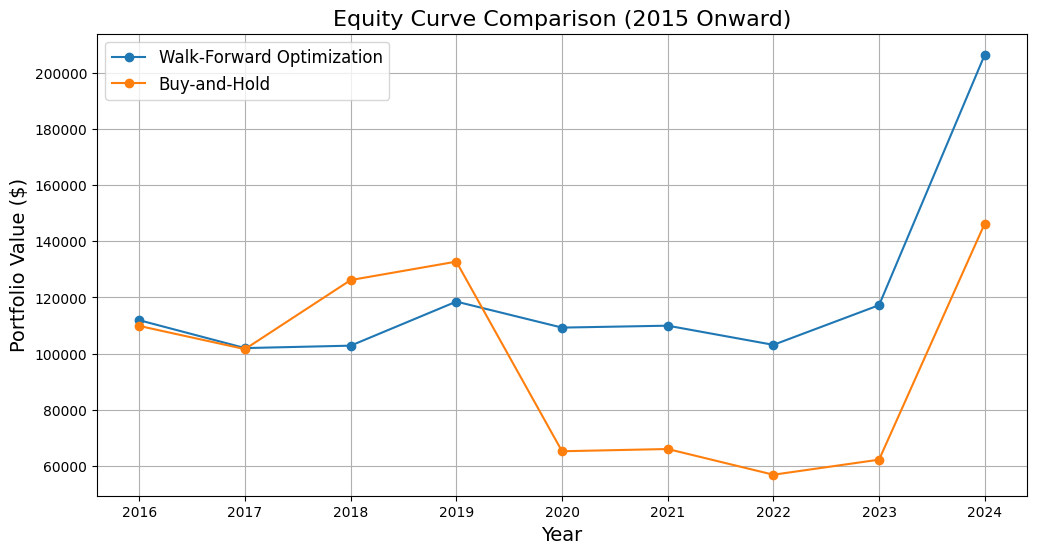

In [54]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt

# Recursive Moving Average (RMA)
def rma(series, alpha=0.1):
    rma_values = [series[0]]
    for i in range(1, len(series)):
        rma_values.append(alpha * series[i] + (1 - alpha) * rma_values[-1])
    return np.array(rma_values)

# Ease of Movement (EMV)
def ease_of_movement(df, period=14):
    df['Distance'] = (df['High'] + df['Low']) / 2 - (df['High'].shift(1) + df['Low'].shift(1)) / 2
    df['Box Ratio'] = (df['Volume'] / 100000) / (df['High'] - df['Low'])
    df['EMV'] = df['Distance'] / df['Box Ratio']
    df['EMV'] = df['EMV'].rolling(window=period).mean()
    return df['EMV']

# Walk-forward optimization
def walk_forward_optimization(df, start_year, end_year, alpha_values, emv_period_values):
    results = []

    for test_year in range(start_year + 2, end_year + 1):
        train_start = test_year - 2
        train_end = test_year - 1
        test_start = test_year
        test_end = test_year

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        test_data = df[df.index.year == test_year]

        best_params = None
        best_performance = -np.inf

        for alpha in alpha_values:
            for emv_period in emv_period_values:
                # Calculate indicators
                train_data['RMA'] = rma(train_data['Close'], alpha=alpha)
                train_data['EMV'] = ease_of_movement(train_data, period=emv_period)

                # Generate entry and exit signals
                entries = (
                    (train_data['Close'] > train_data['RMA']) &
                    (train_data['EMV'] > 0)
                )
                exits = (
                    (train_data['Close'] < train_data['RMA']) &
                    (train_data['EMV'] < 0)
                )

                # Backtest on training data
                portfolio = vbt.Portfolio.from_signals(
                    close=train_data['Close'],
                    entries=entries,
                    exits=exits,
                    init_cash=100_000,
                    fees=0.001
                )

                performance = portfolio.total_return()
                if performance > best_performance:
                    best_performance = performance
                    best_params = (alpha, emv_period)

        # Test with the best parameters
        test_data['RMA'] = rma(test_data['Close'], alpha=best_params[0])
        test_data['EMV'] = ease_of_movement(test_data, period=best_params[1])

        entries = (
            (test_data['Close'] > test_data['RMA']) &
            (test_data['EMV'] > 0)
        )
        exits = (
            (test_data['Close'] < test_data['RMA']) &
            (test_data['EMV'] < 0)
        )

        portfolio = vbt.Portfolio.from_signals(
            close=test_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params,
            'Test_Return': portfolio.total_return()
        })

        # Print the performance for the year
        print(f"Year {test_year}: Walk-Forward Optimization Return = {portfolio.total_return():.2f}")

    return pd.DataFrame(results)

# Define the stock symbol and time period
symbol = 'UAL'
start_date = '2014-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Define parameter grid for optimization
alpha_values = np.linspace(0.01, 0.5)
emv_period_values = range(1, 51)

# Perform walk-forward optimization
results = walk_forward_optimization(df, 2014, 2024, alpha_values, emv_period_values)

# Display results
print("\nWalk-Forward Optimization Results:")
print(results)

# Filter data to include only from 2015 onward
results = results[results['Year'] >= 2015]
df = df[df.index.year >= 2015]

# Initialize equity and cash
initial_cash = 100_000

# Calculate cumulative equity curve based on Test_Return
results['Equity'] = (1 + results['Test_Return']).cumprod() * initial_cash

# Buy-and-Hold Strategy
buy_and_hold_initial_cash = 100_000
df['Daily_Returns'] = df['Close'].pct_change()
df['Buy_and_Hold_Equity'] = (1 + df['Daily_Returns']).cumprod() * buy_and_hold_initial_cash

# Align the buy-and-hold equity curve with the walk-forward results for comparison
buy_and_hold_equity = df.loc[df.index.year.isin(results['Year']), 'Buy_and_Hold_Equity'].resample('Y').last()
buy_and_hold_equity = buy_and_hold_equity.reset_index(drop=True)

# Calculate and print Buy-and-Hold performance
buy_and_hold_total_return = buy_and_hold_equity.iloc[-1] / buy_and_hold_initial_cash - 1
buy_and_hold_cagr = (buy_and_hold_equity.iloc[-1] / buy_and_hold_initial_cash) ** (1 / len(results)) - 1
buy_and_hold_max_drawdown = (buy_and_hold_equity / buy_and_hold_equity.cummax() - 1).min()

print("\nBuy-and-Hold Performance:")
for year, value in zip(buy_and_hold_equity.index, buy_and_hold_equity.values):
    print(f"Year {year}: Buy-and-Hold Return = {value / buy_and_hold_initial_cash - 1:.2f}")

# Comparison plot
plt.figure(figsize=(12, 6))
plt.plot(results['Year'], results['Equity'], marker='o', label='Walk-Forward Optimization')
plt.plot(results['Year'], buy_and_hold_equity.values, marker='o', label='Buy-and-Hold')
plt.title('Equity Curve Comparison (2016 Onward)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Portfolio Value ($)', fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.show()
